<a href="https://colab.research.google.com/github/ctclumak/posts/blob/master/Unsupervised_Clustering_Learning_Retail_Customers_RFM_Segmentation_and_KMeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_excel("/content/Online Retail.xlsx",dtype={"CustomerID":str, "InvoiceNo":str})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [5]:
print("Number of rows that net quantity is negative:",
      df[df.Quantity<0].shape[0])

Number of rows that net quantity is negative: 10624


In [6]:
#Exclude the returns from the database
df=df[df.Quantity>0]

In [7]:
df["TotalSpend"] = df.Quantity*df.UnitPrice

In [8]:
pd.DataFrame(df.groupby(["CustomerID", "Country"]).TotalSpend.sum().sort_values(ascending=False)).describe()

,TotalSpend
count,4347.000000
mean,2050.013320
std,8980.103578
min,0.000000
25%,307.430000
50%,671.960000
75%,1661.195000
max,280206.020000


In [9]:

pd.DataFrame(data=df.isnull().sum()/df.shape[0]*100,index=df.columns, columns=['% Null Values'])

,% Null Values
InvoiceNo,0.000000
StockCode,0.000000
Description,0.111428
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,25.101593
Country,0.000000
TotalSpend,0.000000


In [10]:
df[df.CustomerID.isnull()].TotalSpend.sum()/df.TotalSpend.sum()*100

16.28204877387241

In [11]:
df.dropna(subset=["CustomerID"],inplace=True)
df.shape

(397924, 9)

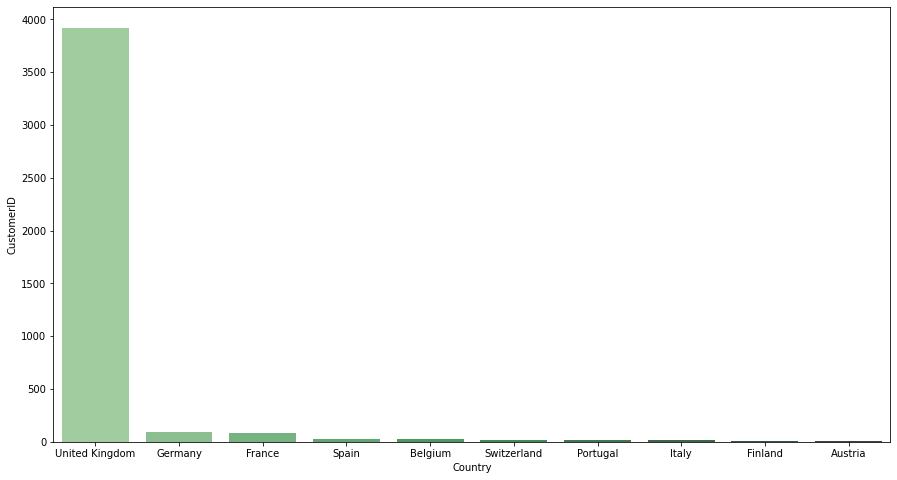

In [12]:
df_country=df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False).reset_index().head(10)
plt.figure(figsize=(15,8))
sns.barplot(data=df_country, x='Country', y='CustomerID',palette="Greens_d")


In [13]:
len(df.query('Country=="United Kingdom"'))/len(df)

0.8904841125441039

**RFM Analysis**

In [14]:
from datetime import datetime
df.InvoiceDate=df.InvoiceDate.dt.date

In [15]:

#Create date variable that records recency
snaptshot_date = max(df.InvoiceDate) + pd.Timedelta(days=1)

#Aggregate data by each customer
customers = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x : (snaptshot_date-x.max()).days,
    "InvoiceNo": "count",
    "TotalSpend": "sum"
})

#rename columns
customers.rename(columns={'InvoiceDate': "Recency", 
                          "InvoiceNo": "Frequency",
                          "TotalSpend": "MonetaryValue"},inplace=True)

In [16]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


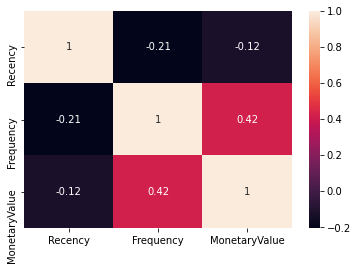

In [17]:
sns.heatmap(customers.corr(),annot=True)

## Manage Skewness

In [18]:
#We will apply Power Transformation to convert these features into a normal distribution
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
customers = pd.DataFrame(pt.fit_transform(customers))
customers.rename(columns={0: "Recency", 
                          1: "Frequency",
                          2: "MonetaryValue"},inplace=True)
customers.head()

,Recency,Frequency,MonetaryValue
0,1.614124,-2.420116,3.193082
1,-1.729289,1.178407,1.377477
2,0.307296,-0.219010,0.745038
3,-0.714932,0.451547,0.728345
4,1.567863,-0.677875,-0.592290


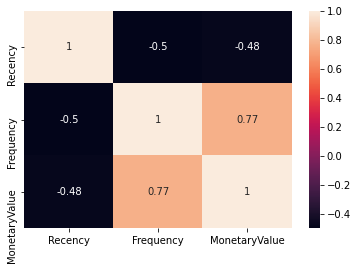

In [19]:
sns.heatmap(customers.corr(),annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

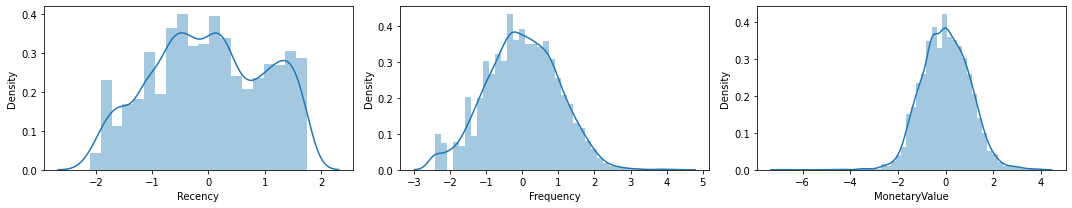

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'],ax=ax[0])
sns.distplot(customers["Frequency"],ax=ax[1])
sns.distplot(customers["MonetaryValue"],ax=ax[2])
plt.tight_layout()
plt.show()

# Normalization

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(customers))


,0,1,2
0,1.614124,-2.420116,3.193082
1,-1.729289,1.178407,1.377477
2,0.307296,-0.219010,0.745038
3,-0.714932,0.451547,0.728345
4,1.567863,-0.677875,-0.592290
...,...,...,...
4334,1.458820,-1.069762,-1.124451
4335,1.055919,-1.322743,-1.853628
4336,-1.243771,-0.936920,-1.137008
4337,-1.600575,2.323804,0.858842


## Dimension Reduction - PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca_transformed = pca.fit_transform(customers)

In [22]:
pca.components_

array([[-0.50701994,  0.61193106,  0.60701826],
       [-0.86144462, -0.33601844, -0.38079494],
       [-0.02905092, -0.71598323,  0.69751276]])

# K-Means Clustering

##Finding the optimal number of clusters

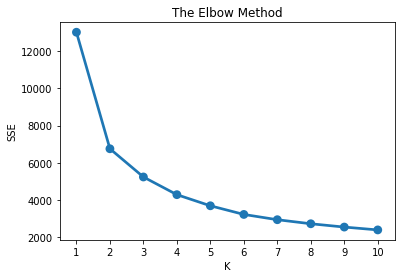

In [31]:
#modeling
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10).fit(customers)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
#inertia is the mean squared distance between each instance and its closest centroid


plt.title("The Elbow Method")
plt.xlabel('K')
plt.ylabel("SSE")
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Based on our observation, the k-value of 2 is the best hyperparameter for our model because the next k-value tend to have a linear trend.**

In [46]:
cluster=KMeans(n_clusters=2,random_state=42)
cluster.fit_transform(customers)
y_pred = cluster.fit_predict(customers)
y_pred.shape, cluster.labels_.shape
#The KMeans instance preserves a copy of the labels of the instances it was trained on, 
#available via the labels_ instance variable

((4339,), (4339,))

**The score() method returns the negative inertia. Why negative? Because a predictor’s score() method must
always respect Scikit-Learn’s “greater is better” rule: if a predictor is better than another, its score() method
should return a greater score.**

In [47]:
cluster.score(customers)

-6750.088761618675

## Model Evaludation - Silhousette Score

In [48]:
from sklearn.metrics import silhouette_score
silhouette_score(customers,cluster.labels_)

0.3969472752885103

## RFM Segementations

In [49]:
recency_score = pd.qcut(customers.Recency, q=3,labels=range(1,4))
frequency_score = pd.qcut(customers.Frequency, q=3,labels=range(1,4))
monetary_score = pd.qcut(customers.MonetaryValue, q=3,labels=range(1,4))
customers=customers.assign(R=recency_score.values, F=frequency_score.values,M=monetary_score.values )
customers

,Recency,Frequency,MonetaryValue,R,F,M
0,1.614124,-2.420116,3.193082,3,1,3
1,-1.729289,1.178407,1.377477,1,3,3
2,0.307296,-0.219010,0.745038,2,2,3
3,-0.714932,0.451547,0.728345,1,2,3
4,1.567863,-0.677875,-0.592290,3,1,1
...,...,...,...,...,...,...
4334,1.458820,-1.069762,-1.124451,3,1,1
4335,1.055919,-1.322743,-1.853628,3,1,1
4336,-1.243771,-0.936920,-1.137008,1,1,1
4337,-1.600575,2.323804,0.858842,1,3,3


## RFM Score

In [52]:
def rfm_score(row):
  return str(row["R"]) + str(row["F"])+str(row["M"])
customers["RFM_Score"]=customers.apply(rfm_score,axis=1)
customers.sort_values("RFM_Score", ascending=False).head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
1936,0.661318,0.812077,0.677230,3,3,3,333
2715,0.690578,0.553137,0.523757,3,3,3,333
1297,1.318297,0.462303,0.480042,3,3,3,333
335,0.668714,0.676759,1.068596,3,3,3,333
1759,1.138362,0.608456,0.582468,3,3,3,333


In [53]:
customers.query('RFM_Score=="333"').sort_values("MonetaryValue", ascending=False)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
2815,0.543166,1.085343,1.964693,3,3,3,333
566,1.451855,1.070410,1.786234,3,3,3,333
3084,0.966443,0.562625,1.573410,3,3,3,333
4017,1.747942,1.570990,1.532788,3,3,3,333
278,0.646358,1.128554,1.463102,3,3,3,333
...,...,...,...,...,...,...,...
1297,1.318297,0.462303,0.480042,3,3,3,333
611,1.519615,0.462303,0.474963,3,3,3,333
1937,0.874534,1.065370,0.467886,3,3,3,333
3970,0.509096,1.055195,0.454893,3,3,3,333


In [54]:
df.query('CustomerID == "16180"').groupby("StockCode").sum().sort_values("Quantity", ascending=False)

,Quantity,UnitPrice,TotalSpend
StockCode,,,
23203,500,8.95,895.00
23199,500,8.95,895.00
23202,500,8.95,895.00
85099B,410,8.97,721.50
23200,400,7.16,716.00
...,...,...,...
23091,3,6.25,18.75
21754,3,5.95,17.85
21745,3,3.75,11.25


In [55]:
RFM_count=pd.DataFrame(customers.RFM_Score.value_counts()).reset_index().rename(columns = {"index":"RFM_Sore", "RFM_Score":"Count"})
RFM_count

,RFM_Sore,Count
0,133,692
1,311,643
2,222,339
3,233,339
4,211,289
5,322,275
6,122,238
7,111,167
8,312,147
9,321,134


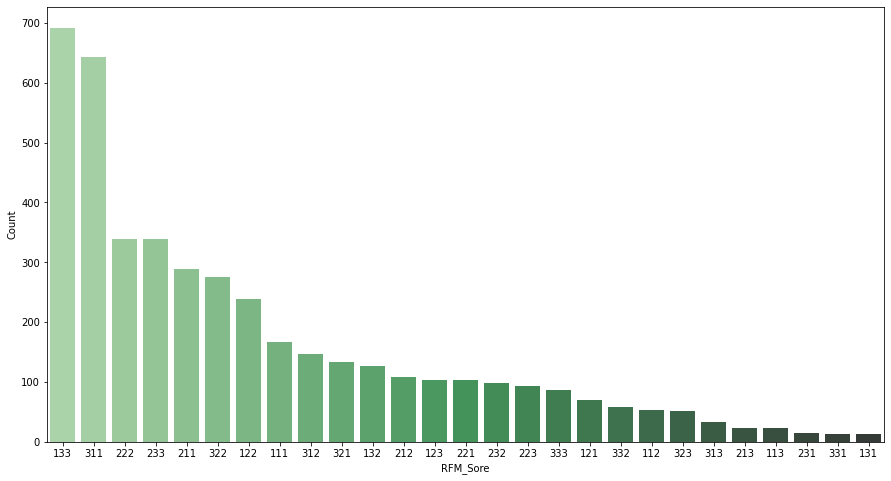

In [58]:
plt.figure(figsize=(15,8))
sns.barplot(data=RFM_count, x='RFM_Sore', y='Count',palette="Greens_d")

In [59]:
def rfm_levels(customers):
  if customers["RFM_Score"]=="313":
    return "Best Customer"
  elif customers["RFM_Score"]=="111":
    return "Lost Cheap Customer"
  elif customers["RFM_Score"]=="133":
    return "Lost Customer"
  elif customers["RFM_Score"]=="233":
    return "Almost Lost Customer"
  elif customers["RFM_Score"]=="311":
    return "New Customers"
  elif customers["F"]==3:
     return "Loyal Customer"
  elif customers["M"]==3:
     return "Big Spender"
  else:
     return "Others"
customers["RFM_Level"] = customers.apply(rfm_levels,axis=1)
customers.iloc[:,6:]

,RFM_Score,RFM_Level
0,313,Best Customer
1,133,Lost Customer
2,223,Big Spender
3,123,Big Spender
4,311,New Customers
...,...,...
4334,311,New Customers
4335,311,New Customers
4336,111,Lost Cheap Customer
4337,133,Lost Customer


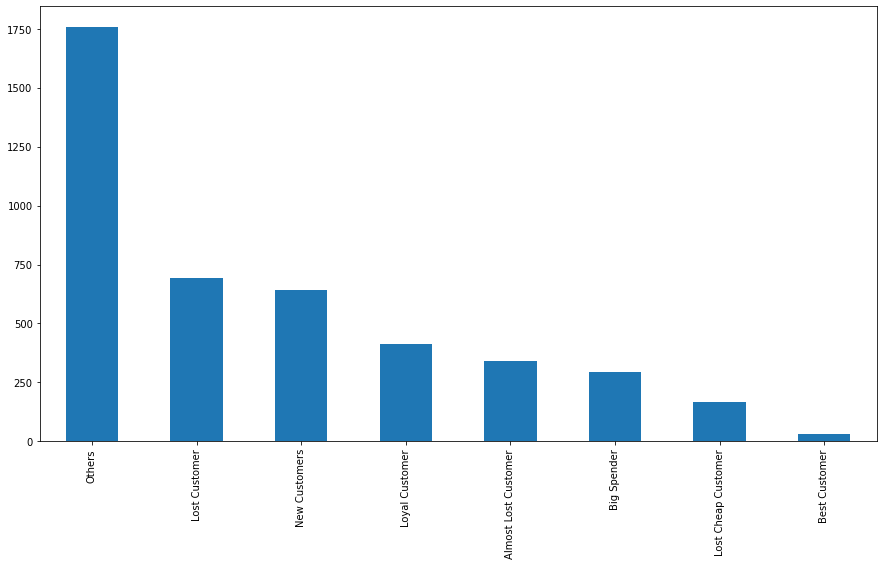

In [60]:
plt.figure(figsize=(15,8))
customers.RFM_Level.value_counts().plot(kind="bar")

In [61]:
customers.query('RFM_Level=="Others"').RFM_Score.value_counts()

222    339
211    289
322    275
122    238
312    147
321    134
212    108
221    103
121     70
112     54
Name: RFM_Score, dtype: int64

In [64]:
rfm_level_agg = customers.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': "mean",
    'MonetaryValue': ['mean', 'count']
}).round(2)
rfm_level_agg

Recency Frequency MonetaryValue      
                        mean      mean          mean count
RFM_Level                                                 
Almost Lost Customer   -0.08      1.01          1.01   339
Best Customer           1.03     -1.21          0.99    33
Big Spender            -0.30     -0.05          0.83   296
Lost Cheap Customer    -0.94     -1.11         -1.10   167
Lost Customer          -1.22      1.29          1.27   692
Loyal Customer         -0.01      0.83          0.16   412
New Customers           1.26     -1.16         -1.17   643
Others                  0.16     -0.34         -0.36  1757

**RFM Table based on clusters**

In [63]:
customers["Cluster"] = cluster.labels_
customers.groupby("Cluster").agg({
    'Recency': 'mean',
    'Frequency': "mean",
    'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          0.59     -0.69         -0.67  2308
1         -0.67      0.78          0.76  2031

##snake plot

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


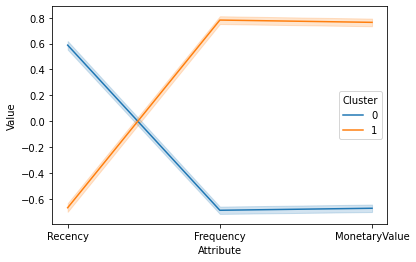

In [65]:
# Create the dataframe
df_normalized = pd.DataFrame(customers, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = cluster.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)